In [1]:
# Import custom helper libraries
import os
import sys

# Set up logging
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


# System modules
import time
import random
import requests
from hashlib import md5
import json


# ML modules
import pandas as pd
import numpy as np
import seaborn as sns

from utils import *

import string

# Sample data for development
TEXT_SAMPLE_SIZE = 10 * 1000  # <= 0 for all
PHOTO_SAMPLE_SIZE = 20 * 1000  # <= 0 for all

INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [3]:
#nltk.download('omw-1.4')

In [4]:
import spacy
# Download SpaCy model
#!python -m spacy download en_core_web_sm

In [5]:
nlp = spacy.load("en_core_web_sm")

nltk.download("stopwords")
nltk.download("wordnet")
stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bartcus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/bartcus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
def reduce_dataframe_memory_usage(df, high_precision = False):
    """
    Iterate through all the columns of a dataframe and modify the data type to
    reduce memory usage.
    Args:
        df (pd.DataFrame): dataframe to reduce memory usage.
        high_precision (bool): If True, use 64-bit floats instead of 32-bit
    Returns:
        pd.DataFrame: dataframe with reduced memory usage.
    """
    start_mem = round(df.memory_usage().sum() / 1024 ** 2, 2)
    logging.info("Memory usage of dataframe is %d MB", start_mem)

    # Iterate through columns
    for col in df.columns:
        if df[col].dtype == "object":
            # "object" dtype
            if df[col].nunique() < max(100, df.shape[0] / 100):
                # If number of unique values is less than max(100, 1%)
                df[col] = df[col].astype("category")
            else:
                # If number of unique values is greater than max(100, 1%)
                df[col] = df[col].astype("string")

        elif str(df[col].dtype)[:3] == "int":
            # "int" dtype
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                df[col] = df[col].astype("UInt8")
            elif c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype("Int8")
            elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                df[col] = df[col].astype("UInt16")
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype("Int16")
            elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                df[col] = df[col].astype("UInt32")
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype("Int32")
            elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                df[col] = df[col].astype("UInt64")
            else:
                df[col] = df[col].astype("Int64")

        elif str(df[col].dtype)[:5] == "float":
            # "float" dtype
            c_min = df[col].min()
            c_max = df[col].max()
            if (
                not high_precision
                and c_min > np.finfo(np.float32).min
                and c_max < np.finfo(np.float32).max
            ):
                df[col] = df[col].astype("float32")
            else:
                df[col] = df[col].astype("float64")

    end_mem = round(df.memory_usage().sum() / 1024 ** 2, 2)
    logging.info("Memory usage after optimization is %d MB", end_mem)
    if start_mem > 0:
        logging.info(
            "Decreased by %d %%", round(100 * (start_mem - end_mem) / start_mem)
        )

    return df

# Review dataset

In [7]:
if os.path.exists("data/processed/reviews.pkl.gz"):
    # Load academic data from pickle file
    logger.info(">>> Loading reviews from pickle file...")
    reviews_df = pd.read_pickle("data/processed/reviews.pkl.gz")
    logger.info(f">>> OK : {len(reviews_df)} reviews loaded from pickle file.")
else:
    # Load academic data from row CSV file
    logger.info(">>> Loading reviews from JSON file...")
    reviews_df = pd.DataFrame()
    with pd.read_json(
        "data/yelp_dataset/yelp_academic_dataset_review.json",
        dtype={
            "review_id": str,
            "user_id": str,
            "business_id": str,
            "stars": int,
            "useful": int,
            "funny": int,
            "cool": int,
            "text": str,
            "date": "datetime64[ns]",
        },
        chunksize=500 * 1000,
        lines=True,
    ) as json_reader:
        # Load data in chunks
        for chunk in json_reader:
            reviews_df = reviews_df.append(chunk)
            logger.info(f"Loaded {len(reviews_df)} reviews")
    logger.info(f">>> OK : {len(reviews_df)} reviews loaded from JSON file.")

    # Reduce memory usage
    reviews_df = reduce_dataframe_memory_usage(reviews_df)

    # Save as pickle
    logger.info(">>> Saving reviews data as pickle file...")
    os.makedirs("data/processed/", exist_ok=True)
    reviews_df.to_pickle("data/processed/reviews.pkl.gz")
    logger.info(
        ">>> OK : Reviews data saved to data/processed/reviews.pkl.gz ."
    )

if TEXT_SAMPLE_SIZE > 0:
    # Sample data
    logger.info(">>> Sampling reviews data...")
    reviews_df = reviews_df.sample(TEXT_SAMPLE_SIZE, random_state=1)
    logger.info(f">>> OK : Data sampled to {len(reviews_df)} reviews.")

INFO:__main__:>>> Loading reviews from pickle file...
INFO:__main__:>>> OK : 6990280 reviews loaded from pickle file.
INFO:__main__:>>> Sampling reviews data...
INFO:__main__:>>> OK : Data sampled to 10000 reviews.


In [8]:
reviews_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
5095865,grCKx4FxYyUwdnOBhQfX0g,JfmoxgXfQ0Ry0p9BpUeiuw,wX4ap0Qy5ZK6Hy2iKvBqXA,5,0,0,0,Some of the best Italian I've had anywhere. Ev...,2014-09-23 01:07:43
5738483,AcEJifrPG10UuFL4U5PatQ,FIGKtYfnOf9lulst6SfYHA,vYRqUvqE7T7rnHjLjTB2tQ,5,1,0,0,"Excellent food, wonderful nice staff. The Pho ...",2016-02-29 23:58:37
1759834,DuTIRuFSQyfNHvaWuB7IOw,PAhPFMahii5gfB3WSDX0DQ,nCqQf0L0GsVHxub7BDESaA,1,0,0,0,Super slow service. Place was not busy Food wa...,2019-02-15 16:18:20
5208919,snT2LwnMGFYQBIj9QvaL_Q,fJhQQKVrq2z_01PVEEDW4g,AWcelHEIYKzk348Q2htKmQ,5,0,0,0,This YMCA is top of the line! It is only a li...,2013-01-22 16:06:57
4569498,PlgTJzVt7-6-fVPFxJ0R-A,rmYFZaQsJiBrmuGY6DfzRg,WtuSRpjR3aI_3Y7t9YwR2Q,5,0,0,0,Walked in and got Lucy. She was wonderful. I w...,2019-03-22 21:55:56


In [9]:
reviews_df = reviews_df.reset_index(drop=True)

## EDA

In [10]:
reviews_df.describe()

,stars,useful,funny,cool
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.738500,1.171700,0.300800,0.478000
std,1.482005,2.760685,1.306863,1.781469
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000,0.000000
max,5.000000,95.000000,52.000000,95.000000


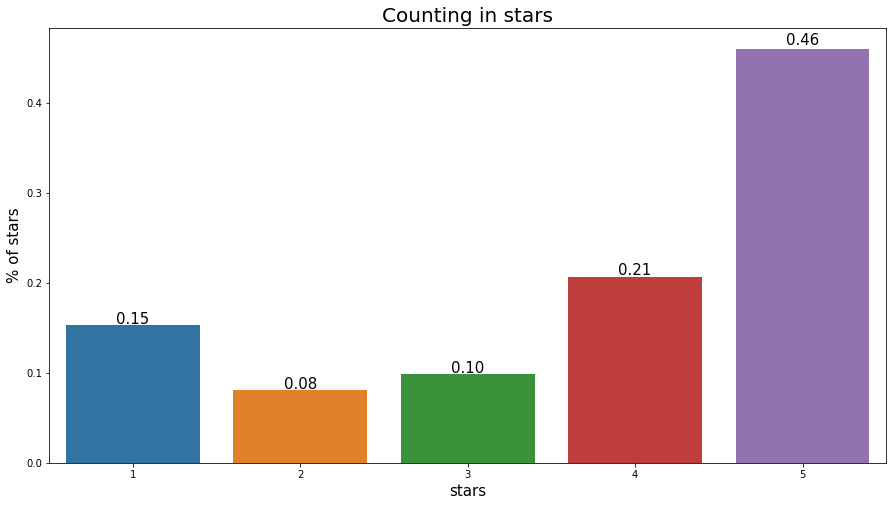

In [11]:
plot_count_col(reviews_df, col= 'stars', label_col='stars', show_val=True)

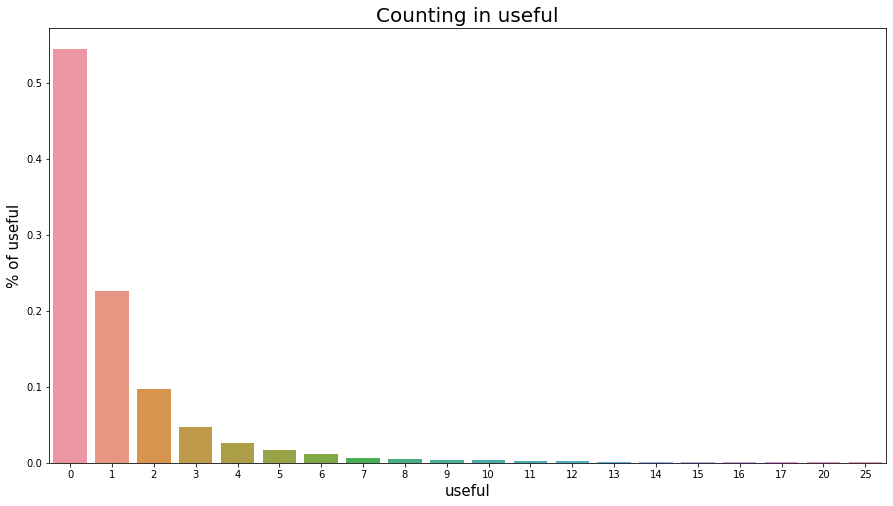

In [12]:
plot_count_col(reviews_df, col= 'useful', label_col='useful', show_val=False, top=20)

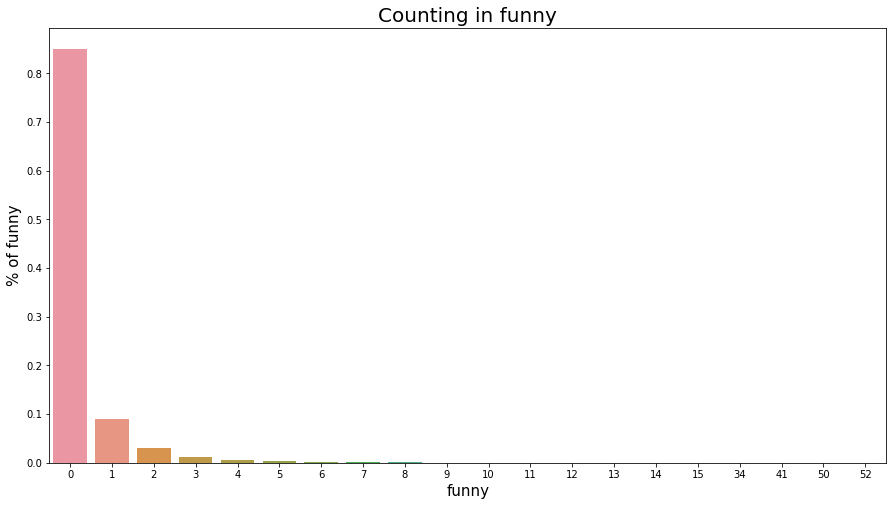

In [13]:
plot_count_col(reviews_df, col= 'funny', label_col='funny', show_val=False)

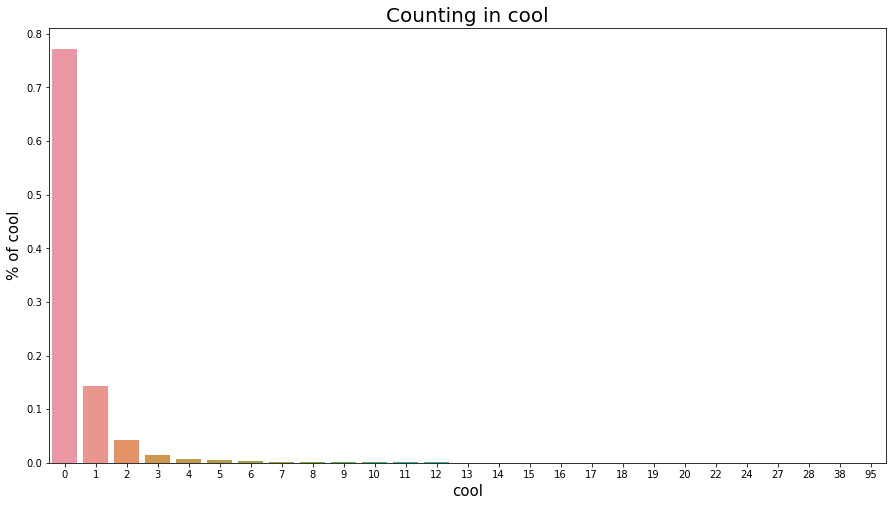

In [14]:
plot_count_col(reviews_df, col= 'cool', label_col='cool', show_val=False)

In [15]:
reviews_df.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

***How much reviews per user***

In [16]:
reviews_df.groupby('user_id').agg('count')

,review_id,business_id,stars,useful,funny,cool,text,date
user_id,,,,,,,,
--9jUPPYMRSnJKlOskyyDA,1,1,1,1,1,1,1,1
-02tzlpQosZ9HE85jEtV6Q,1,1,1,1,1,1,1,1
-0KrCHEsOcjJ6N4k_k1A9A,1,1,1,1,1,1,1,1
-0mrmedVkALZ0w-wROseZQ,1,1,1,1,1,1,1,1
-1XU-0De2TKEwNRmmRU2KA,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
zy3gG5D284CRO9Rsd4trFg,1,1,1,1,1,1,1,1
zzBhA0M7NNBMYoWj48h53A,1,1,1,1,1,1,1,1
zzUKixXipsKL-bzTQ2wwPw,1,1,1,1,1,1,1,1


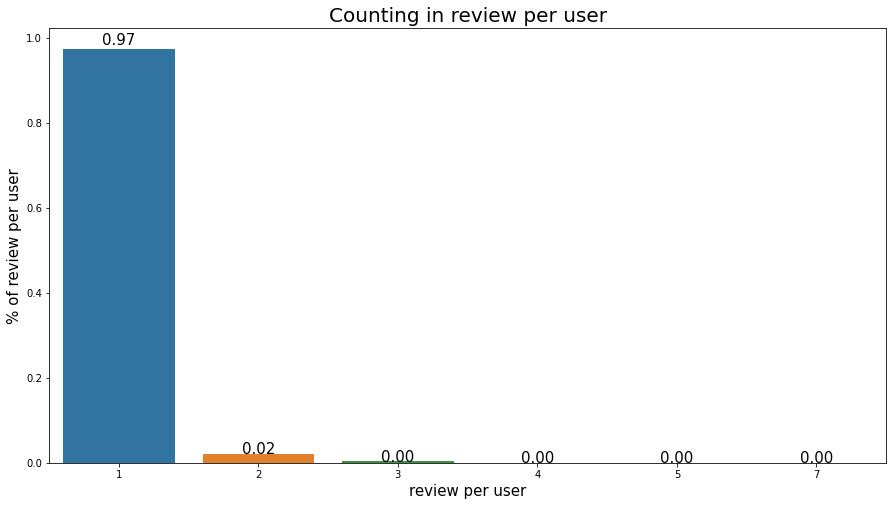

In [17]:
plot_count_col(reviews_df.groupby('user_id').agg('count'), col= 'review_id', label_col='review per user', show_val=True)

97% of users gived just 1 review.

***How much bussiness per review?***

In [18]:
reviews_df.groupby('business_id').agg('count')

,review_id,user_id,stars,useful,funny,cool,text,date
business_id,,,,,,,,
-0G_6-KFGpCpxTUlVXCMYQ,2,2,2,2,2,2,2,2
-0TffRSXXIlBYVbb5AwfTg,3,3,3,3,3,3,3,3
-0gRYq5UjMtZbELj0KHxzA,2,2,2,2,2,2,2,2
-1XSzguS6XLN-V6MVZMg2A,1,1,1,1,1,1,1,1
-1q3O9hvYmrELU39_Thbzw,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
zxIF-bnaJ-eKIsznB7yu7A,3,3,3,3,3,3,3,3
zxuVnNVAUm16Sro0dS_lmg,1,1,1,1,1,1,1,1
zyFlGv7TXKquCmXrC8cp4Q,1,1,1,1,1,1,1,1


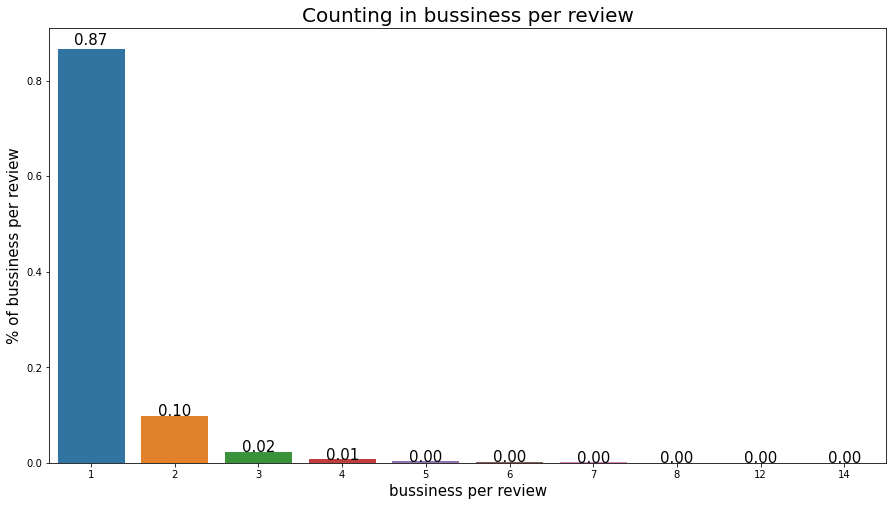

In [19]:
# Number of reviews per business
plot_count_col(reviews_df.groupby('business_id').agg('count'), col= 'review_id', label_col='bussiness per review', show_val=True)

87% of bussiness has 1 review, 2 reviews has 10% of bussienss, 3 reviews has 2 % of bussienss, 5 and more reviews has less then 1% of bussiness.

***How much review per star?***

In [20]:
reviews_df.groupby('stars').agg('count').review_id

stars
1    1534
2     813
3     987
4    2066
5    4600
Name: review_id, dtype: int64

One can see that the highest number of review is for the star equat to 5. 

In [21]:
reviews_df.groupby('stars').agg('max')[['useful', 'funny', 'cool']]

,useful,funny,cool
stars,,,
1,95,34,27
2,18,12,12
3,39,50,38
4,27,15,28
5,92,52,95


One can see that the most useful review are with stars 1 and 5. Also reviews with stars 5 are the funniest and the coolest.

Let us see if there are missing values in the reviews:

In [22]:
missing_values_table(reviews_df)

Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Also let us see if there are review text that does not contains any text.

In [23]:
reviews_df[reviews_df.text=='']

,review_id,user_id,business_id,stars,useful,funny,cool,text,date


## Defining negative comments - sentiment analysis

In [24]:
#from sklearn.model_selection import train_test_split


X = reviews_df["text"]
y = reviews_df["stars"]

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)


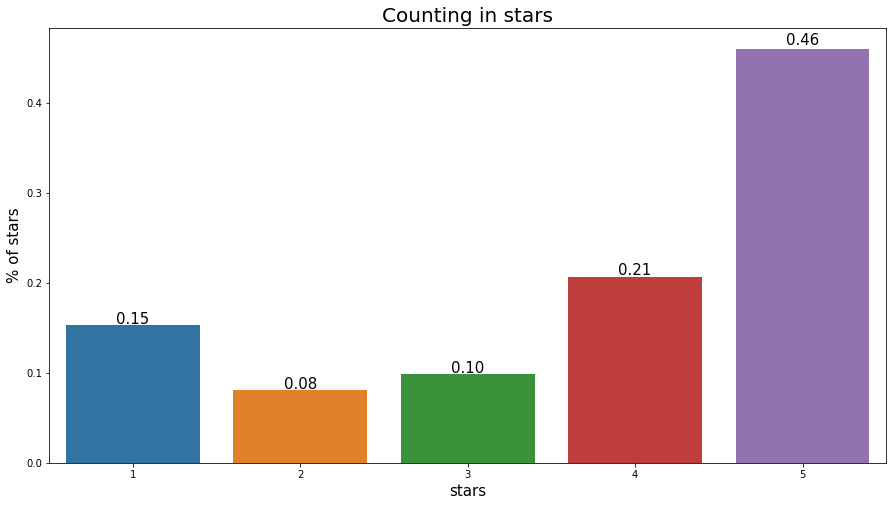

In [25]:
plot_count_col(reviews_df, 'stars', label_col='stars', show_val = True, on_x=True)

***Binary segmentation:*** We can see that we have more positive reviews than negative ones. Let us assume that 1, 2 stars are review that are associated with negative sentiments, 3, 4, 5 are associated with positive sentiments.

In [26]:
reviews_df.loc[:,'sentiment'] = 1
reviews_df.loc[reviews_df.stars<3, 'sentiment']=0

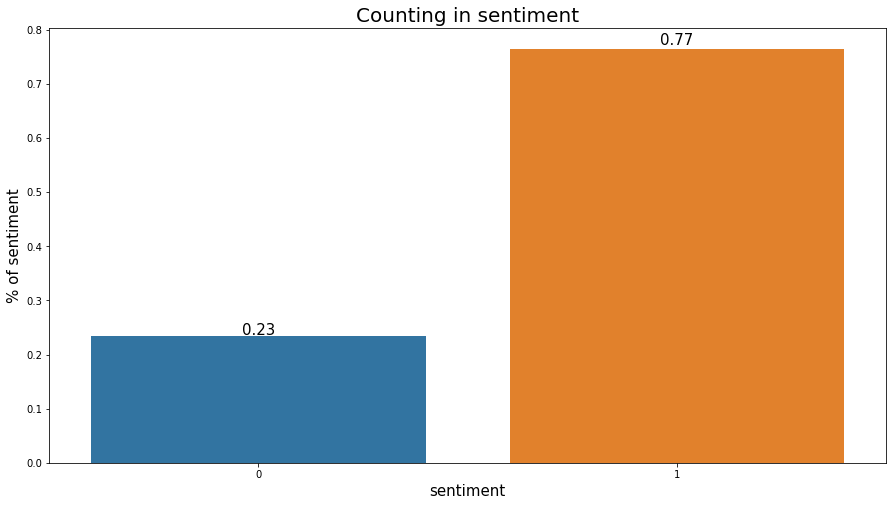

In [27]:
plot_count_col(reviews_df, 'sentiment', label_col='sentiment', show_val = True, on_x=True)

In [28]:
reviews_df.sentiment.value_counts()

1    7653
0    2347
Name: sentiment, dtype: int64

Here we can see that 23% of data are with negative sentiments and 77% of data are with positive sentiments.

In [29]:
#yb_train = [0 if x<3 else 1 for x in y_train]
#yb_test = [0 if x<3 else 1 for x in y_test]

## Peprocess and set Features Bag of words

In [30]:
def preprocess_text2(text):
    text = text.lower()
    #text = word_tokenize(text)
    text = nlp(text)
    
    tokens = [token.lemma_ for token in text if
              (not token.is_punct
              and not token.is_currency
              and not token.is_digit
              and not token.is_punct
              and not token.is_space
              and not token.is_stop
              and not token.like_num
              and not token.pos_ == "PROPN"
              )]
    
    # Initialize a stemmer
    ps = PorterStemmer()
    # and stem (remove suffix of the word)
    tokens = [ps.stem(tk) for tk in tokens]
    
    tokens = [t for t in tokens if t in wordnet.words()] # verify if the word exists in the wordnet
    
    
    text = set(tokens) - stopwords
    
    return text

In [31]:
def preprocess_text(text):
    text = text.lower()
    #text = word_tokenize(text)
    text = nlp(text)
    
    tokens = [token.lemma_ for token in text if
              (not token.is_punct
              and not token.is_currency
              and not token.is_digit
              and not token.is_punct
              and not token.is_space
              and not token.is_stop
              and not token.like_num
              and not token.pos_ == "PROPN"
              )]
    
    # Initialize a stemmer
    ps = PorterStemmer()
    # and stem (remove suffix of the word)
    tokens = [ps.stem(tk) for tk in tokens]
    
    tokens = [t for t in tokens if t in wordnet.words()] # verify if the word exists in the wordnet
    
    
    text = set(tokens) - stopwords
    
    return ' '.join(text)

In [32]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)   
Y = X.parallel_apply(lambda x: preprocess_text(x) ) 

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [33]:
word_count = pd.DataFrame(pd.DataFrame(Y).text.str.split(expand=True).stack().value_counts())
word_count = word_count.reset_index()
word_count.columns=['word', 'count']
word_count

,word,count
0,good,4324
1,food,3565
2,place,3544
3,great,3210
4,time,2856
...,...,...
6434,leer,1
6435,goon,1
6436,paddlefish,1
6437,encompass,1


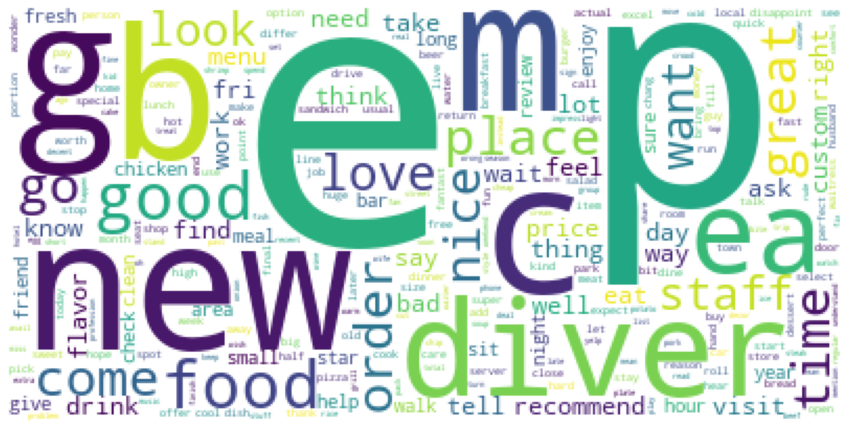

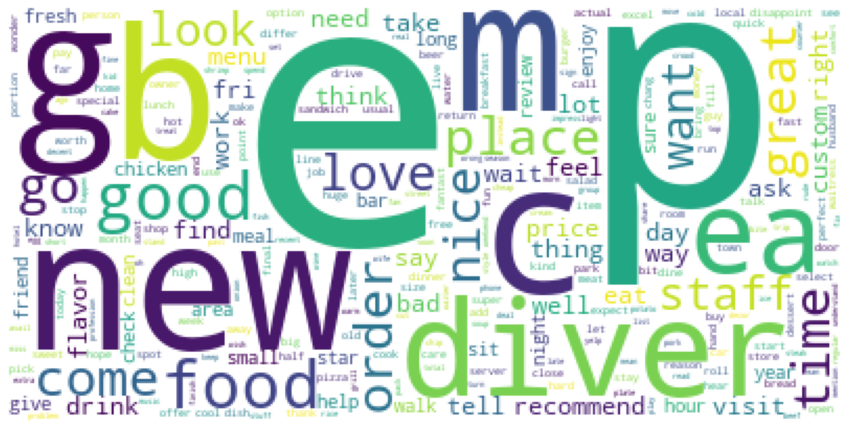

In [34]:
plot_words(word_count, col='word', height = 15, wieght = 10)

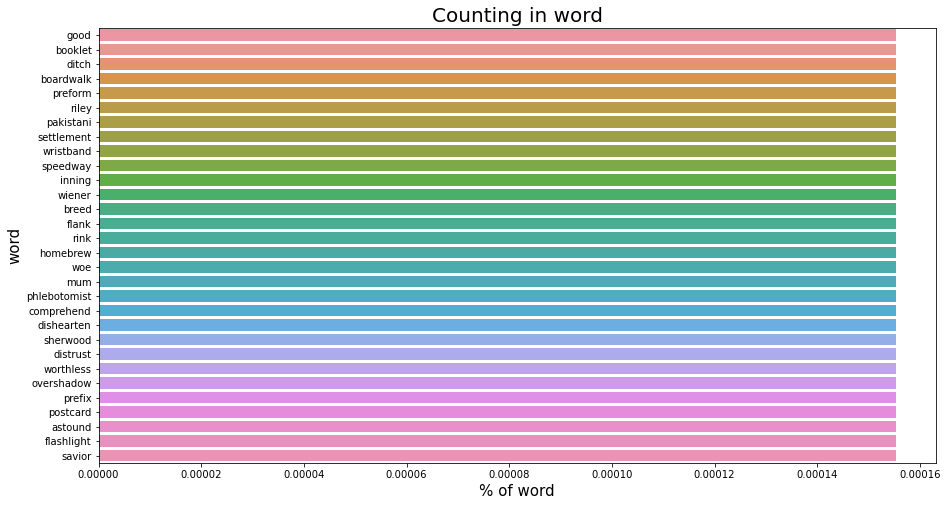

In [35]:
plot_count_col(word_count, 'word', label_col='word', show_val = False, on_x=False, top=30)

In [36]:
vectorizers = [CountVectorizer(), #0
               TfidfVectorizer(), #1 not very satisfying
               CountVectorizer(strip_accents="unicode", 
                               lowercase=True, 
                               stop_words='english', 
                               analyzer='word'), #2
               CountVectorizer(strip_accents="unicode", 
                               lowercase=True, 
                               stop_words='english', 
                               analyzer='word', 
                               ngram_range=(1,2)),#3
               TfidfVectorizer(strip_accents="unicode", 
                               lowercase=True, 
                               stop_words='english', 
                               analyzer='word', 
                               max_df=0.9,
                               min_df=0.01),#4
               TfidfVectorizer(strip_accents="unicode", 
                               lowercase=True, 
                               stop_words='english', 
                               analyzer='word', 
                               max_df=0.9,
                               min_df=0.01,
                               ngram_range=(1,2)),#5
               TfidfVectorizer(strip_accents="unicode", 
                               lowercase=True, 
                               stop_words='english', 
                               analyzer='word'),#6  not very satisfying
               TfidfVectorizer(strip_accents="unicode", 
                               lowercase=True, 
                               stop_words='english', 
                               analyzer='word', 
                               max_features=1000),#7
               TfidfVectorizer(strip_accents="unicode", 
                               lowercase=True, 
                               stop_words='english', 
                               analyzer='word', 
                               max_df=0.9,
                               min_df=0.01,
                               ngram_range=(1,2),
                               max_features=1000),#8
               ]

In [37]:
with timer("Data vectorization"):
    X_v = {}
    df_nlp_review = {}
    for index, vect in enumerate(vectorizers):
        X_v[index] = {}
        X_v[index]['vect'] = vect.fit_transform(Y)
        X_v[index]['feature_names'] = vect.get_feature_names()#to get the names of the tokens
        dense = X_v[index]['vect'].todense() #convert sparse matrix to numpy array
        denselist = dense.tolist() #convert array to List
        df_nlp_review[index] = pd.DataFrame(denselist, columns=X_v[index]['feature_names']) #convert to dataframe

/opt/anaconda3/envs/oc6/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/oc6/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/oc6/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/oc6/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get

Data vectorization - done in 315s


In [38]:
index = 4
words_count = pd.DataFrame(
        data = np.column_stack((X_v[index]['feature_names'], X_v[index]['vect'].sum(axis=0).tolist()[0])) ,
    columns=['word', 'freq']
)

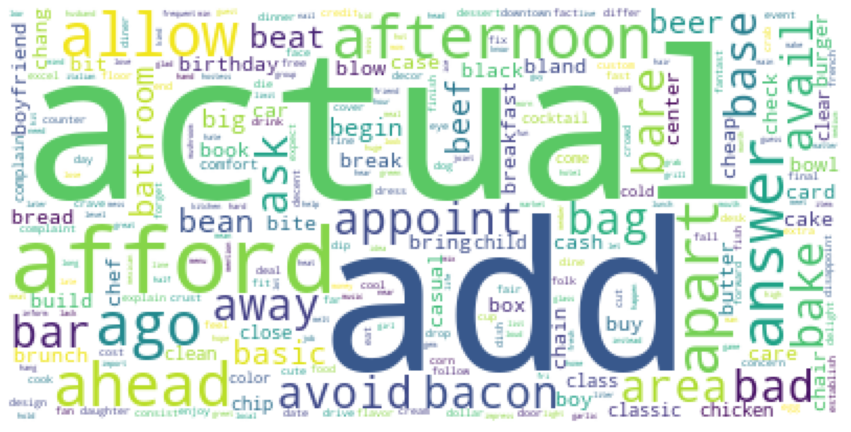

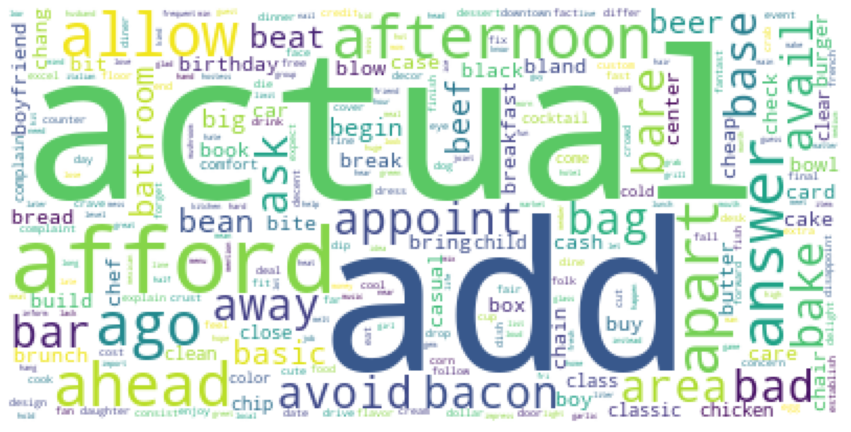

In [39]:
plot_words(words_count, col='word', height = 15, wieght = 10)

## Text Classification - SVM

Support vector machinie (SVM) is an machine learning algorithm that gives the possibility to make classification or regression. It consists in separating the maximum number of exemples sampled from different classes (hard margin classifier).

Before we purcede to applying the model we should separate the data in training and testing datasets in order to evaluate our model. Than we apply the model on the training set and compute the f1 score between the label obtained on traing and thoose predicted on testing set.

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
X_train, X_test, y_train, y_test = train_test_split(df_nlp_review[index], reviews_df.sentiment, test_size = 0.3)
clf = LinearSVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('F1 Score :', f1_score(y_test, y_pred))

F1 Score : 0.9134024984120263


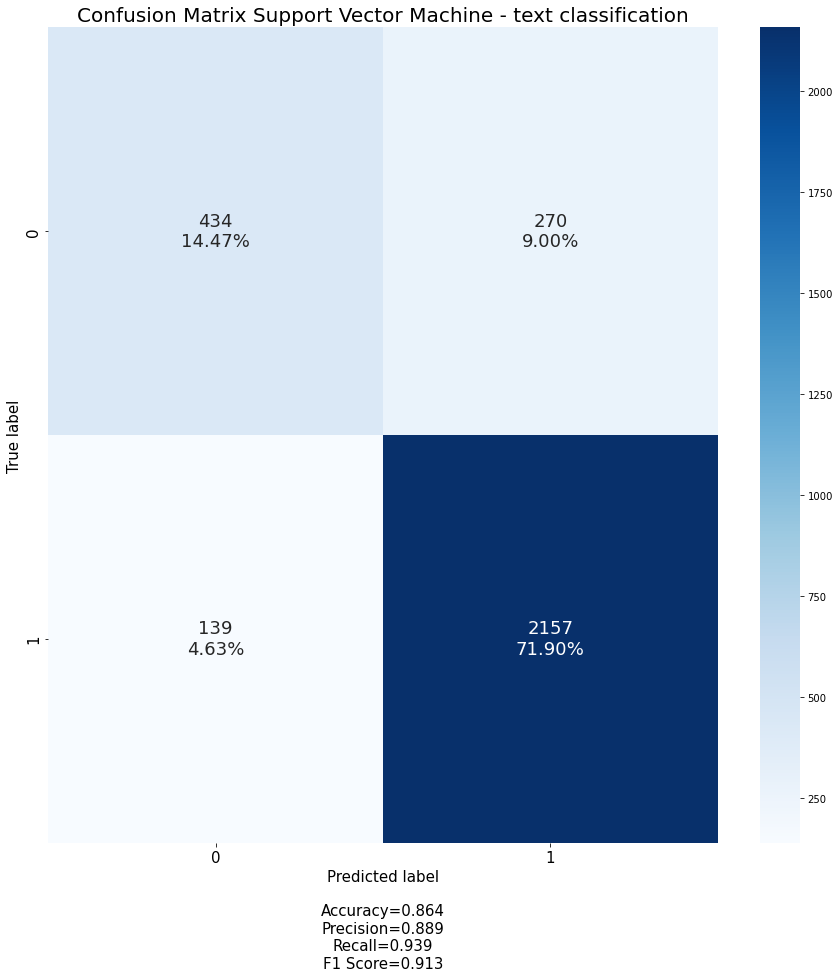

In [141]:
make_confusion_matrix(confusion_matrix(y_test, y_pred), figsize=(15, 15), title='Confusion Matrix Support Vector Machine - text classification')

## Topic analysis

Here we will analise the topics of the reviews in ordrer to understand better the satisfaction or insatisfaction of clients. 

We use different technics to indentify the topics. The one that is the most pertinent will be preserved and disscussed.

 - LSA : Latent Semantic Analysis (LSA) is a method for dimensionality reduction. It is a supervised method that uses a matrix decomposition to project the data into a lower dimensional space.
 - LDA : Latent Dirichlet Allocation (LDA) is a probabilistic model that uses a probabilistic graphical model to infer the topic distribution of a document.
 - NMF: Non-Negative Matrix Factorization (NMF). Find two non-negative matrices, i.e. matrices with all non-negative elements, (W, H) whose product approximates the non-negative matrix X. This factorization can be used for example for dimensionality reduction, source separation or topic extraction.

In [40]:
n_topics = 10 # number of choosen topics
no_top_words = 10 # number of top words to show per topic

In [41]:
def plot_top_words(model, feature_names, n_top_words, n_topics, title):
    n_cols = 5
    n_lines = int(np.ceil(min(n_topics, model.n_components) / n_cols))
    fig, axes = plt.subplots(n_lines, n_cols, figsize=(30, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_[0:n_topics]):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=30)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [42]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

### LSA

In [43]:
from sklearn.decomposition import TruncatedSVD
# Fit the LSA model
logging.info(
    "Fitting the LSA model with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (df_nlp_review[index].shape[0], df_nlp_review[index].shape[1])
)
with timer("creation and fitting lsa model"):
    lsa = TruncatedSVD(n_components=n_topics, random_state=1)
    lsa.fit_transform(df_nlp_review[index])

INFO:root:Fitting the LSA model with tf-idf features, n_samples=10000 and n_features=488...


creation and fitting lsa model - done in 0s


In [44]:
display_topics(lsa, X_v[index]['feature_names'], no_top_words)

Topic 0:
good food place great time come like order love staff
Topic 1:
food great good love chicken fri place fresh excel menu
Topic 2:
great staff recommend love help clean place price job work
Topic 3:
food time custom order great bad wait come ask excel
Topic 4:
recommend chicken job excel salad thank fri love order wonder
Topic 5:
price good reason like chicken buy high job fri work
Topic 6:
love place pizza custom bad come good food staff know
Topic 7:
staff nice clean help wait super order fresh stay food
Topic 8:
recommend good place time lot area come visit wait worth
Topic 9:
price love excel reason food menu portion visit wonder worth


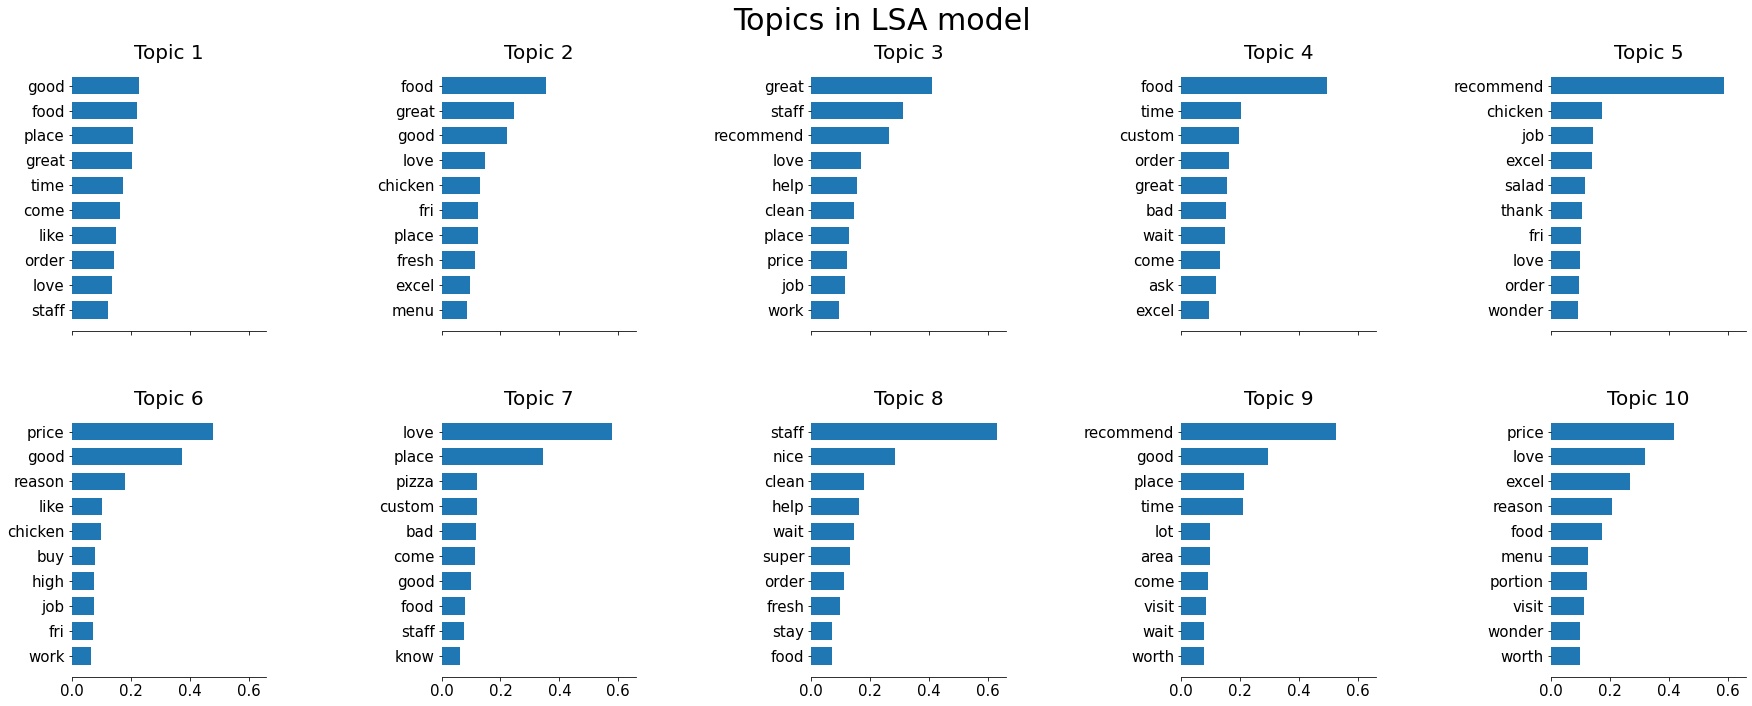

In [45]:
plot_top_words(
    lsa, X_v[index]['feature_names'], no_top_words, n_topics, "Topics in LSA model" # (Frobenius norm)
)

### LDA - sklearn

In [46]:
from sklearn.decomposition import LatentDirichletAllocation

# Fit the LDA model
logging.info(
    "Fitting the LDA model with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (df_nlp_review[index].shape[0], df_nlp_review[index].shape[1])
)

with timer("creation and fitting lda model"):
    # Créer le modèle LDA
    lda = LatentDirichletAllocation(
            n_components=n_topics, 
            #max_iter=5, 
            learning_method='online', 
            #learning_offset=50.,
            random_state=1)

    # Fitter sur les données
    lda.fit(df_nlp_review[index])

INFO:root:Fitting the LDA model with tf-idf features, n_samples=10000 and n_features=488...


creation and fitting lda model - done in 13s


In [47]:
display_topics(lda, X_v[index]['feature_names'], no_top_words)

Topic 0:
time tell custom like say work come ask want need
Topic 1:
mexican pricey salsa chip taco nail die rice bean prefer
Topic 2:
great place bar good drink food beer love fun nice
Topic 3:
save wish pm far bad star wall sale forget room
Topic 4:
food good great seafood pasta server oyster dish excel shrimp
Topic 5:
pizza crust steak cake dessert slice glass order wine good
Topic 6:
ice good wing chicken food great cream fri sandwich order
Topic 7:
great recommend staff job food place good custom love clean
Topic 8:
place good food price like item great order menu eat
Topic 9:
food good order place flavor chicken egg great eat come


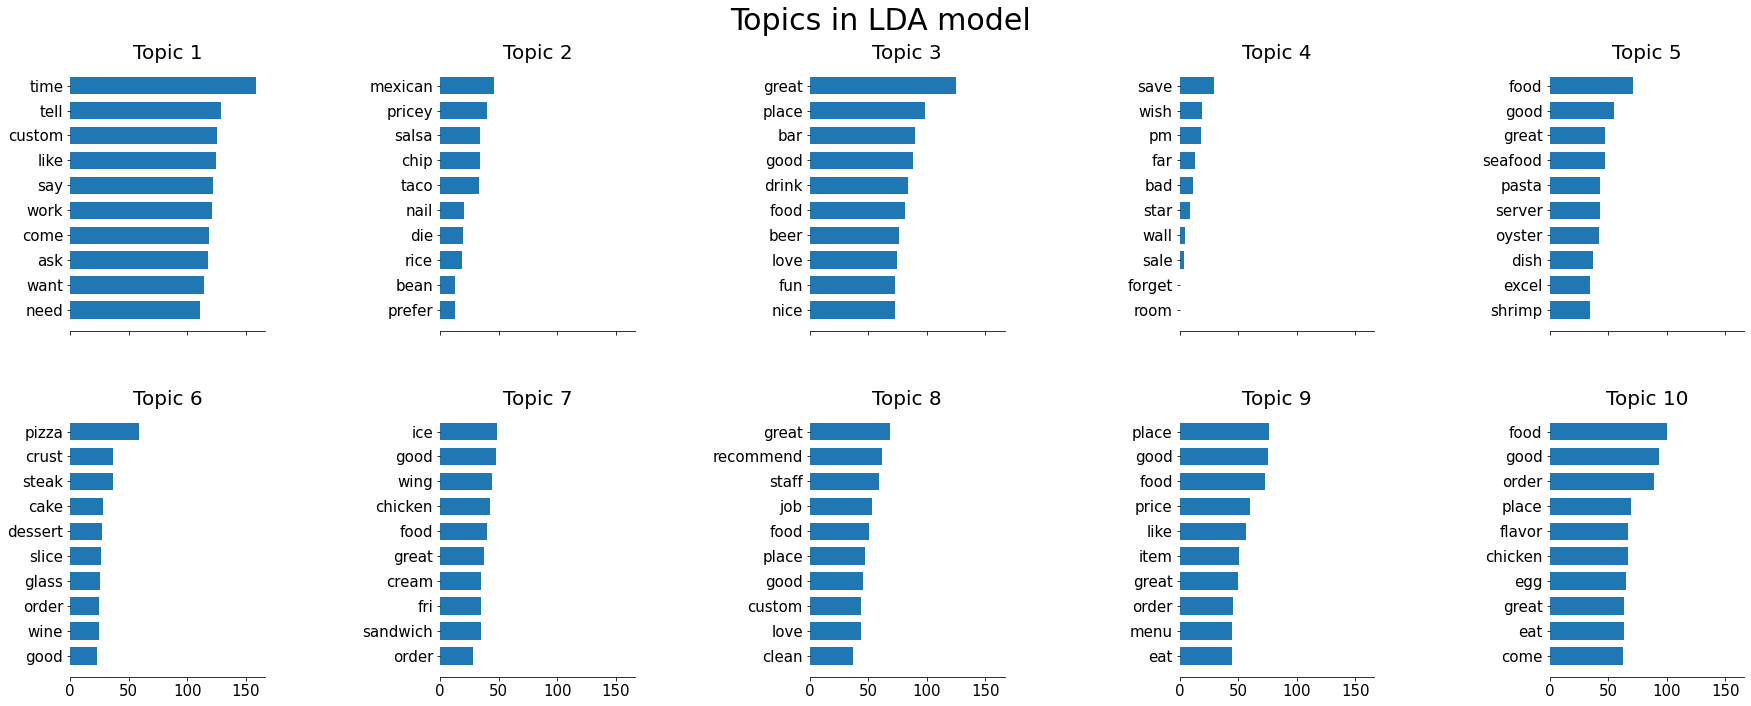

In [48]:
plot_top_words(
    lda, X_v[index]['feature_names'], no_top_words, n_topics, "Topics in LDA model" # (Frobenius norm)
)

### LDA - gensim

In [49]:
logging.getLogger().setLevel(logging.CRITICAL)

In [121]:
# in order to show jupyter lab buttons  - problem of pyLDAvis package: https://github.com/bmabey/pyLDAvis/issues/162
from IPython.display import HTML 
css_str = '<style> \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>' 
display(HTML(css_str))

In [51]:
from gensim.models import LdaMulticore, CoherenceModel, TfidfModel
from gensim.corpora import Dictionary

In [52]:
docs = X.parallel_apply(lambda x: preprocess_text2(x) ) #X.map(preprocess_text2)

In [53]:
dictionary = Dictionary(docs)

In [54]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [55]:
tfidf = TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]

In [100]:
# Topics range
min_topics = 2
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

In [101]:
# In order to get the optimal number of topics we get the perplexity and coherence scores for the LDA model for diffenrent number of topics
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

if (not os.path.exists('results/model_results_ab.csv')):
    # Alpha parameter
    alpha = list(np.arange(0.01, 1, 0.3))
    alpha.append('symmetric')
    alpha.append('asymmetric')

    # Beta parameter
    beta = list(np.arange(0.01, 1, 0.3))
    beta.append('symmetric')


    model_results = {'Topics': [],
                     'Alpha': [],
                     'Beta': [],
                     'Coherence': []
                    }

    with timer("computing the number of topics"):
        #computing the number of topics - done in 16042s
        for k in topics_range:

            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # Build the LDA model
                    lda_model = LdaMulticore(
                            corpus=corpus,
                            id2word=dictionary,
                            num_topics=k,
                            random_state=100,
                            chunksize=100,
                            passes=10,
                            alpha=a,
                            eta=b
                    )
                    # get the coherence score for the given parameters
                    coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
                    cv = coherence_model_lda.get_coherence() 

                    # Save the model results
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)   
                    print('a:{0} b:{1} k:{2} coherence:{3}'.format(a, b, k, cv))
model_results = pd.DataFrame(model_results)
model_results.to_csv('results/model_results_ab.csv')  

In [99]:
model_results.describe()

,Topics,Coherence
count,540.000000,540.000000
mean,10.500000,0.569291
std,5.192938,0.052819
min,2.000000,0.387799
25%,6.000000,0.543313
50%,10.500000,0.588718
75%,15.000000,0.605773
max,19.000000,0.640395


In [106]:
# Topics range
min_topics = 2
max_topics = 50
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

if (not os.path.exists('results/model_results.csv')):
    model_results = {'Topics': [],
                     'Coherence': []
                    }

    with timer("computing the number of topics"):
        #computing the number of topics - done in 
        for k in topics_range:
            # Build the LDA model
            lda_model = LdaMulticore(
                    corpus=corpus,
                    id2word=dictionary,
                    num_topics=k,
                    random_state=100,
                    chunksize=2000,
                    passes=10,
                    per_word_topics=True,
            )
            # get the coherence score for the given parameters
            coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
            cv = coherence_model_lda.get_coherence() 

            # Save the model results
            model_results['Topics'].append(k)
            model_results['Coherence'].append(cv)   
            print('k:{0} coherence:{1}'.format(k, cv))
model_results = pd.DataFrame(model_results)
model_results.to_csv('results/model_results.csv')  

k:2 coherence:0.5924749560653226
k:3 coherence:0.5929104015734892
k:4 coherence:0.5861317715564602
k:5 coherence:0.5844569771632735
k:6 coherence:0.5875472214377785
k:7 coherence:0.5734709890863309
k:8 coherence:0.5874950609231122
k:9 coherence:0.58177041306074
k:10 coherence:0.5792446938689915
k:11 coherence:0.5724736370261895
k:12 coherence:0.5808510889449806
k:13 coherence:0.5737743721522065
k:14 coherence:0.5751233920361278
k:15 coherence:0.5795448001621324
k:16 coherence:0.5838791306054674
k:17 coherence:0.5803536755058778
k:18 coherence:0.5894288956915598
k:19 coherence:0.5844455680995194
k:20 coherence:0.5855149898542462
k:21 coherence:0.5821604570009511
k:22 coherence:0.5810387555546438
k:23 coherence:0.5858776390546627
k:24 coherence:0.5866700926883066
k:25 coherence:0.5899535210172976
k:26 coherence:0.5873347866602541
k:27 coherence:0.5878073047235222
k:28 coherence:0.5843794112951868
k:29 coherence:0.5832111178514785
k:30 coherence:0.5747258516154543
k:31 coherence:0.5766993

/var/folders/1y/1jw5mb9979bdkjf9r9nkdrq00000gn/T/ipykernel_51274/1442809531.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(axes.get_yticks(), size=15)


Text(0, 0.5, 'Coherence score')

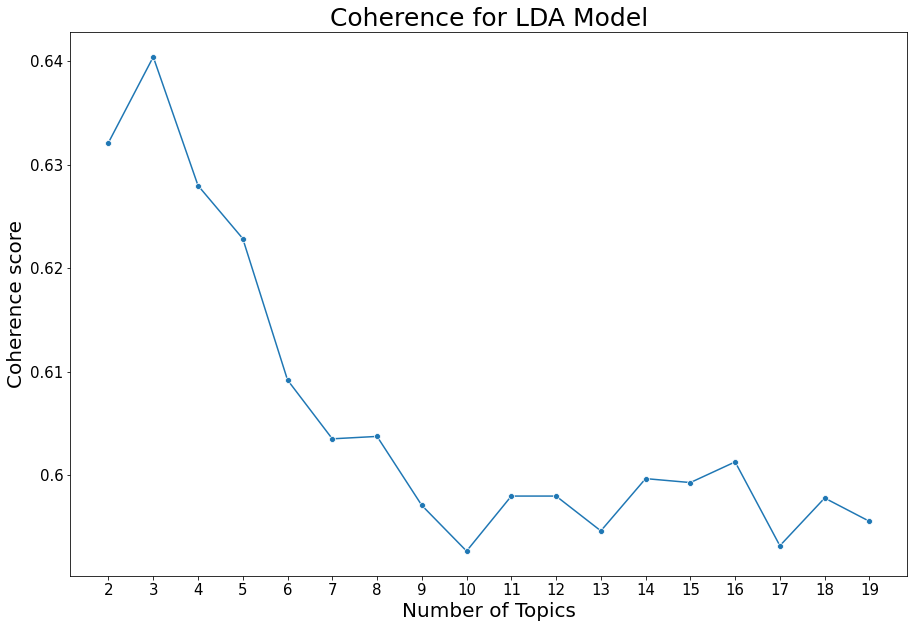

In [84]:
a = model_results[model_results.Coherence == model_results.Coherence.max()].Alpha.iloc[0]
b = model_results[model_results.Coherence == model_results.Coherence.max()].Beta.iloc[0]

plt.figure(figsize=(15, 10))
axes = sns.lineplot(data=model_results[(model_results.Alpha==a)&(model_results.Beta==b)], x="Topics", y="Coherence", marker="o")
axes.set_xticks(model_results[(model_results.Alpha==a)&(model_results.Beta==b)].Topics);
# use
axes.set_xticklabels(axes.get_xticks(), size=15)
axes.set_yticklabels(axes.get_yticks(), size=15)
plt.title('Coherence for LDA Model',fontsize=25)
plt.xlabel('Number of Topics',fontsize=20)
plt.ylabel('Coherence score',fontsize=20)

In [70]:
import pyLDAvis
import pyLDAvis.gensim_models

n_topics = model_results[model_results.Coherence == model_results.Coherence.max()].Topics.iloc[0]
a = model_results[model_results.Coherence == model_results.Coherence.max()].Alpha.iloc[0]
b = model_results[model_results.Coherence == model_results.Coherence.max()].Beta.iloc[0]

pyLDAvis.enable_notebook()

lda_model = LdaMulticore(
                        corpus=corpus_tfidf,
                        id2word=dictionary,
                        num_topics=n_topics,
                        random_state=100,
                        chunksize=100,
                        passes=10,
                        alpha=a,
                        eta=b
                )

pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

/opt/anaconda3/envs/oc6/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/envs/oc6/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/oc6/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/oc6/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/oc6/lib/python3.9/site-packages/p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.235333 -0.021095       1        1  36.411880
0     -0.146403 -0.119019       2        1  32.995959
2     -0.088931  0.140113       3        1  30.592161, topic_info=        Term         Freq        Total Category  logprob  loglift
116      fri   737.000000   737.000000  Default  30.0000  30.0000
563   burger   498.000000   498.000000  Default  29.0000  29.0000
5       food  1554.000000  1554.000000  Default  28.0000  28.0000
621     beer   573.000000   573.000000  Default  27.0000  27.0000
186    store   444.000000   444.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
159    price   368.830934   983.709179   Topic3  -5.3593   0.2034
569   flavor   329.964646   684.452659   Topic3  -5.4706   0.4548
519  chicken   333.827354   747.289338   Topic3  -5.4590   0.3786
112    drink   335.001913   798.163857   Topic3  -5.4555   0.3162
187    think   320.086427   734.341949   Topic3  -5.5010   0.3540

[328 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
492       1  1.001451  address
2273      2  1.002756    adult
854       1  0.989974   answer
854       3  0.009900   answer
1417      1  0.994677  appoint
...     ...       ...      ...
258       3  0.527909    worth
1881      3  0.995502     yeah
42        1  0.686041     year
42        2  0.186255     year
42        3  0.127275     year

[572 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [142]:
lda_model = LdaMulticore(
                        corpus=corpus_tfidf,
                        id2word=dictionary,
                        num_topics=10,
                        random_state=100,
                        chunksize=2000,
                        passes=10,
                        per_word_topics=True,
                )

pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

/opt/anaconda3/envs/oc6/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/envs/oc6/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/oc6/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/oc6/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/oc6/lib/python3.9/site-packages/p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.040349 -0.040515       1        1  36.846708
2     -0.029990 -0.035850       2        1  24.192196
7      0.085070 -0.057188       3        1  16.369137
4     -0.073922  0.014281       4        1   7.052096
1      0.007048 -0.017033       5        1   4.478782
9     -0.021189  0.010117       6        1   3.123844
0     -0.006098 -0.000354       7        1   3.105113
3      0.014104  0.007697       8        1   2.574772
8      0.056400  0.049996       9        1   1.210137
6      0.008928  0.068850      10        1   1.047215, topic_info=      Term         Freq        Total Category  logprob  loglift
5     food  1249.000000  1249.000000  Default  30.0000  30.0000
25   great  1257.000000  1257.000000  Default  29.0000  29.0000
0     good  1178.000000  1178.000000  Default  28.0000  28.0000
12   place  1161.000000  1161.000000  Default  27.0000  27.0000
210   love   969.000000   969.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
154     go     6.187915   936.360494  Topic10  -6.0724  -0.4604
42    year     5.617377   566.249254  Topic10  -6.1692  -0.0541
7     nice     5.831001   869.732208  Topic10  -6.1318  -0.4460
158    new     5.453689   552.764001  Topic10  -6.1987  -0.0596
142   wait     5.513252   776.357001  Topic10  -6.1879  -0.3884

[853 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
3586      1  0.075996    60
3586      2  0.075996    60
3586      3  0.759955    60
1000      1  0.062289    ab
1000      2  0.747474    ab
...     ...       ...   ...
4438      1  0.143270  zing
4438      2  0.143270  zing
4438      3  0.143270  zing
4438      4  0.143270  zing
4438      7  0.429811  zing

[4088 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 8, 5, 2, 10, 1, 4, 9, 7])

### NMF

In [50]:
from sklearn.decomposition import NMF


# Fit the NMF model
logging.info(
    "Fitting the NMF model with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (df_nlp_review[index].shape[0], df_nlp_review[index].shape[1])
)

# Run NMF
with timer("creation and fitting nmf model"):
    nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=1, init='nndsvd')
    
    
    nmf.fit(df_nlp_review[index])

INFO:root:Fitting the NMF model with tf-idf features, n_samples=10000 and n_features=488...
/opt/anaconda3/envs/oc6/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


creation and fitting nmf model - done in 1s


In [51]:
display_topics(nmf, X_v[index]['feature_names'], no_top_words)

Topic 0:
order eat menu like place drink come fresh flavor enjoy
Topic 1:
time work need custom tell say know day come ask
Topic 2:
great beer select place fun job bar fantast spot town
Topic 3:
food good place time fast come bad mexican ok town
Topic 4:
chicken fri salad rice sandwich burger wing order beef garlic
Topic 5:
price reason high fair select portion worth item decent good
Topic 6:
love place option come wonder kid week spot new cute
Topic 7:
staff nice help clean super place hotel room stay visit
Topic 8:
recommend job wonder profession place super relax fantast time friend
Topic 9:
excel wine lunch dine dinner server job wow wife free


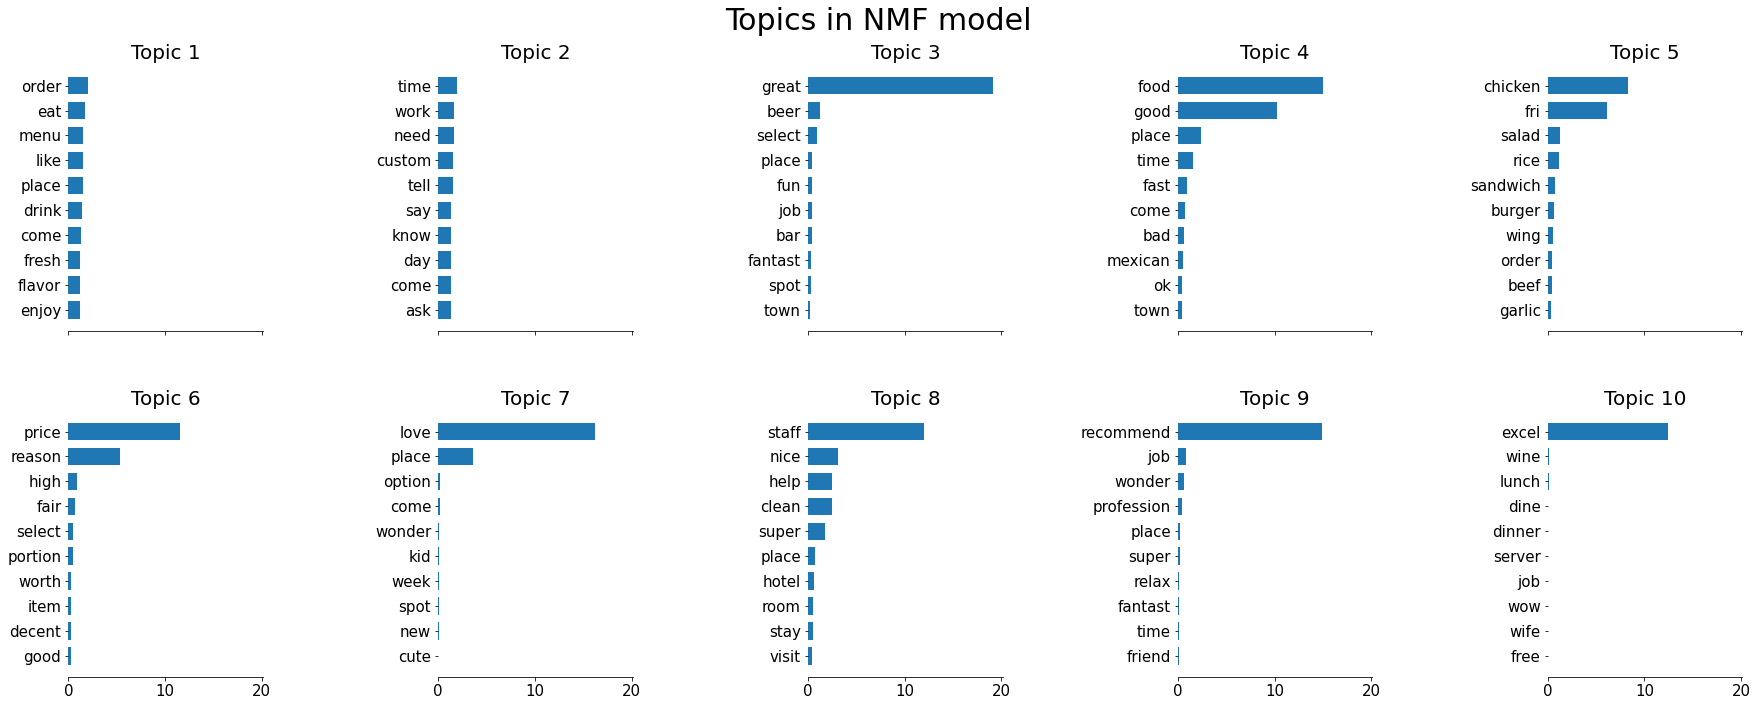

In [52]:
plot_top_words(
    nmf, X_v[index]['feature_names'], no_top_words, n_topics, "Topics in NMF model" # (Frobenius norm)
)

## Word Embedding

In [146]:
from gensim.models.word2vec import Word2Vec


word2vec = Word2Vec(docs)
word2vec.wv.most_similar(["chicken"], topn=10)

[('steak', 0.9776007533073425),
 ('grit', 0.9471451640129089),
 ('wine', 0.944852888584137),
 ('perfect', 0.9424423575401306),
 ('pork', 0.938063383102417),
 ('italian', 0.9355652332305908),
 ('dessert', 0.9342963099479675),
 ('cocktail', 0.933874785900116),
 ('top', 0.9320082664489746),
 ('pizza', 0.9288530945777893)]

In [171]:
from sklearn.manifold import TSNE

X_w2v = pd.DataFrame([word2vec.wv[x] for x in word2vec.wv.key_to_index.keys()])
X_tsne = TSNE(random_state=1, n_jobs=-1).fit_transform(X_w2v)
X_tsne = pd.DataFrame(X_tsne, columns=['T1', 'T2'])

/opt/anaconda3/envs/oc6/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/oc6/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


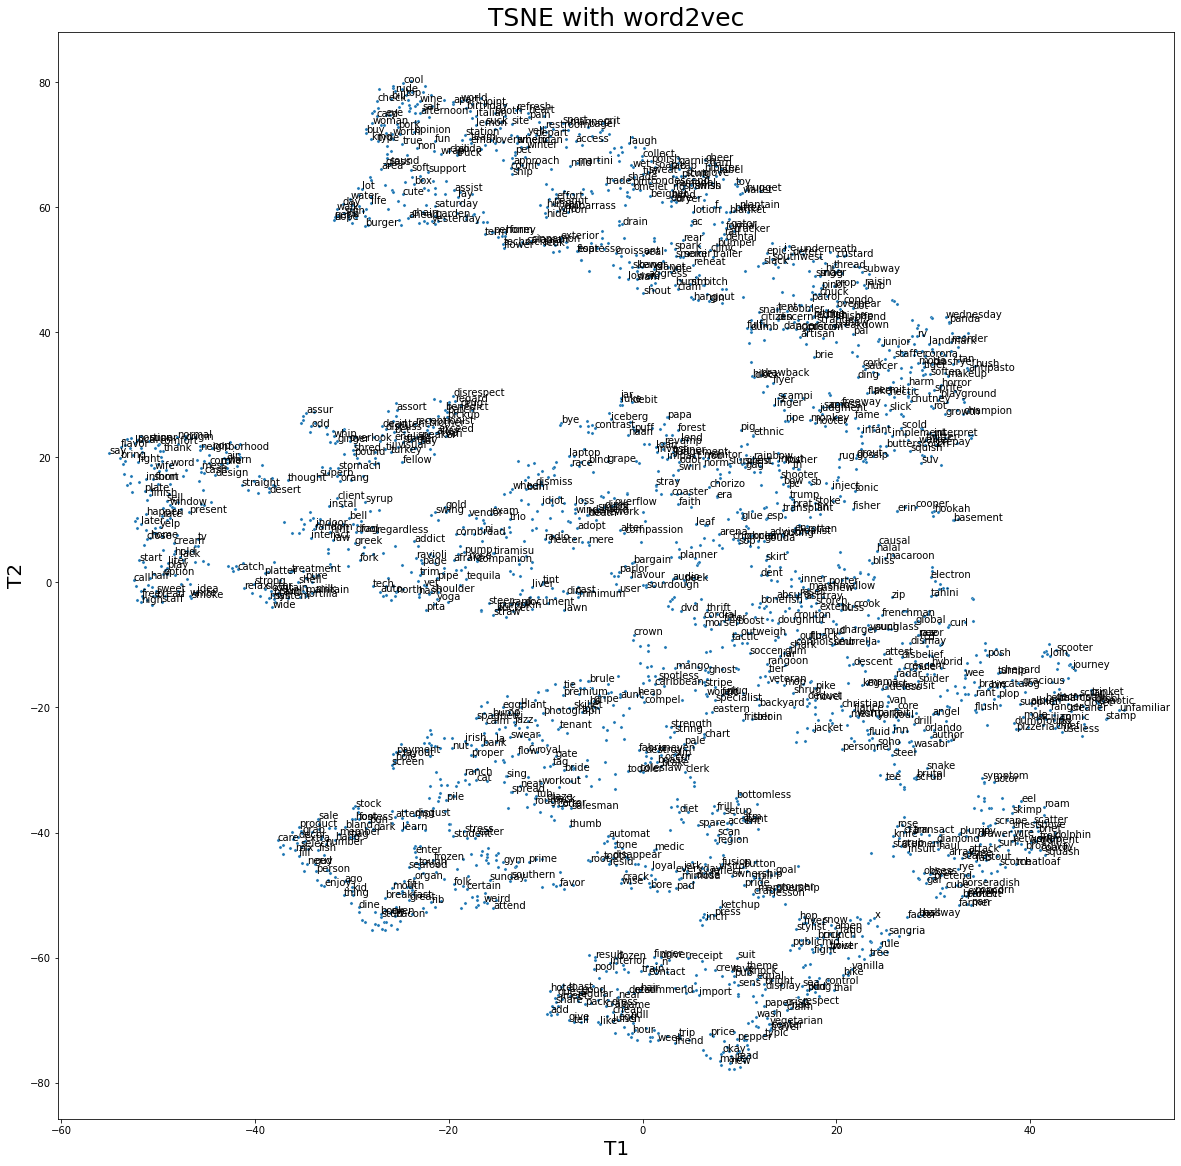

In [184]:
plt.figure(figsize=(20, 20))
sns.scatterplot(
    #x=X_tsne[:, 0],
    #y=X_tsne[:, 1],
    #text=word2vec.wv.key_to_index.keys(),
    data = X_tsne,
    x="T1", y="T2",
    s=10
);
# Annotate label points 
for i, word in enumerate(word2vec.wv.key_to_index.keys()):
    if (i % 3)==0:
        plt.annotate(word, (X_tsne.T1[i], X_tsne.T2[i]) )
    
plt.title('TSNE with word2vec',fontsize=25);
plt.xlabel('T1',fontsize=20);
plt.ylabel('T2',fontsize=20);

In [177]:
enumerate(word2vec.wv.key_to_index.keys())

# Photos dataset

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['lines.linewidth'] = 2
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

In [ ]:
photos_df = pd.DataFrame()
with pd.read_json("data/yelp_photos/photos.json",
    chunksize=500 * 1000,
    lines=True,
) as json_reader:
    # Load data in chunks
    for chunk in json_reader:
        photos_df = photos_df.append(chunk)
        logger.info(f"Loaded {len(photos_df)} photos")
logger.info(f">>> OK : {len(photos_df)} photos loaded from JSON file.")

# Reduce memory usage
photos_df = reduce_dataframe_memory_usage(photos_df)

In [ ]:
if PHOTO_SAMPLE_SIZE > 0:
    sampled_photos_df = pd.DataFrame()
    for label in photos_df.label.unique():
        sampled_photos_df = sampled_photos_df.append(
            photos_df[photos_df.label == label].sample(
                int(PHOTO_SAMPLE_SIZE / (len(photos_df.label.unique()))),
                random_state=0, replace=True
            )
        )
else:
    sampled_photos_df = photos_df

sampled_photos_df.describe(include="all")

In [ ]:
photos_df.shape

In [ ]:
photos_df.head()